# Problem 1 - GRU for Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import string
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# Prepare torch gpu
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
# Using GPU device
gpu_device = torch.device("cuda:0")

True
Quadro RTX 5000 with Max-Q Design


## Part 1 - Preprocessing (5 points)

In [3]:
# Loading data
train_pos_load = pd.read_table("data/train_pos_merged.txt", header = None, sep = "\n").values
train_neg_load = pd.read_table("data/train_neg_merged.txt", header = None, sep = "\n").values

test_pos_load = pd.read_table("data/test_pos_merged.txt", header = None, sep = "\n").values
test_neg_load = pd.read_table("data/test_neg_merged.txt", header = None, sep = "\n").values

In [4]:
# Check the size of each dataset
len(train_neg_load), len(train_neg_load), len(test_pos_load), len(test_neg_load)

(1500, 1500, 1500, 1500)

In [5]:
# Pipeline function to strip punctuation, build vocab list, and return 400 fix length vector for each
def pre_processing(train_pos, train_neg, test_pos, test_neg):
    # Create the labels for train set and combine into one array later
    # Where 1 is positive and 0 is negative
    train_labels = np.zeros(len(train_pos) + len(train_neg))
    train_labels[:len(train_pos)] = 1 
    
    # Create the labels for test set and combine into one array later
    # Where 1 is positive and 0 is negative
    test_labels = np.zeros(len(test_pos) + len(test_neg))
    test_labels[:len(train_pos)] = 1
    
    strip_punc = str.maketrans('', '', string.punctuation)
    # Strip punctuation and combine train set positive and negative
    train_data = []
    for data in train_pos:
        train_data.append(np.array(data[0].translate(strip_punc).split()))
    for data in train_neg:
        train_data.append(np.array(data[0].translate(strip_punc).split()))
    train_data = np.array(train_data)
    # For test set
    test_data = []
    for data in test_pos:
        test_data.append(np.array(data[0].translate(strip_punc).split()))
    for data in test_neg:
        test_data.append(np.array(data[0].translate(strip_punc).split()))
    test_data = np.array(test_data)
    
    # Build dictionary and vector of the training and testing data at once
    word_dictionary = {"":0}
    word_count = 1
    training_vec = []
    # Only building words from the train data
    for i in range(len(train_data)):
        temp_review_vec = []
        # Only using the first 400 words
        for j in range(min(len(train_data[i]), 400)):
            if train_data[i][j] not in word_dictionary:
                word_dictionary[train_data[i][j]] = word_count
                word_count += 1
            temp_review_vec.append(word_dictionary[train_data[i][j]])
        # Pad 0's at the begining if less than 400 words
        while len(temp_review_vec) < 400:
            temp_review_vec.insert(0, 0)
        training_vec.append(np.array(temp_review_vec))
    training_vec = np.array(training_vec)
            
    # Now making the vector for test data
    testing_vec = []
    for i in range(len(test_data)):
        temp_review_vec = []
        # User all words in review for loop, break if more than 400 in dictionary words
        for j in range(len(test_data[i])):
            if test_data[i][j] not in word_dictionary:
                continue
            temp_review_vec.append(word_dictionary[test_data[i][j]])
            # Break loop if reach 400 word limit
            if len(temp_review_vec) == 400:
                break
        # Pad 0's at the begining if less than 400 words
        while len(temp_review_vec) < 400:
            temp_review_vec.insert(0, 0)
        testing_vec.append(np.array(temp_review_vec))
    testing_vec = np.array(testing_vec)
    
    return word_dictionary, training_vec, train_labels, testing_vec, test_labels

In [6]:
# Run the pipeline and store everything in numpy
word_dict, training_vec, training_label, testing_vec, testing_label = pre_processing(train_pos_load,
                                                                                    train_neg_load,
                                                                                    test_pos_load,
                                                                                    test_neg_load)

In [7]:
print("There are", len(word_dict), "words in the word dictionary")

There are 40096 words in the word dictionary


In [8]:
# Put data into pytorch
train_data = TensorDataset(torch.from_numpy(training_vec).type(torch.LongTensor),
                           torch.from_numpy(training_label).type(torch.LongTensor))
train_loader = DataLoader(train_data, shuffle = True, batch_size = 64)

test_data = TensorDataset(torch.from_numpy(testing_vec).type(torch.LongTensor),
                          torch.from_numpy(testing_label).type(torch.LongTensor))
test_loader = DataLoader(test_data, shuffle = True, batch_size = 64)

In [9]:
# The reverse dictionary look up
word_lookup = {a: b for b, a in word_dict.items()}

In [10]:
# A function to revert a tensor back to sentense
def revert_sentence(data_tensor):
    numpy_vector = data_tensor.cpu().detach().numpy()
    sentence_vec = np.delete(numpy_vector, np.where(numpy_vector == 0))
    sentence = []
    for each in sentence_vec:
        sentence.append(word_lookup[each])
    return " ".join(sentence)

## Part 2 - Build A Binary Prediction RNN with GRU (10 points)

In [11]:
class rnn_gru(nn.Module):
    def __init__(self):
        super(rnn_gru, self).__init__()
        self.embedding = nn.Embedding(len(word_dict), 256)
        self.gru = nn.GRU(256, 128, 3, batch_first = True)
        self.fc = nn.Linear(128, 2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        # Taking the result from gru, index 1
        out = out[1][-1]
        out = self.fc(out)
        out = self.sigmoid(out)
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds

In [12]:
gru_model = rnn_gru()
gru_model.to(gpu_device)

rnn_gru(
  (embedding): Embedding(40096, 256)
  (gru): GRU(256, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [13]:
# Set the cross-entrophy criterion
gru_cross_entro = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
gru_sgd = optim.Adam(gru_model.parameters(), lr = 0.01)

In [14]:
# Training function from my previous assignment, changing it to binary 
# Train function taken from my own train function from question 2
def train_model(model, dataloader_train, dataloader_test, optimizer, criterion, num_epochs):    
    # Run all the epochs
    all_train_acc = []
    all_train_loss = []
    all_test_acc = []
    all_test_loss = []
    for epoch in range(num_epochs):
        # Run both train and test stage in each epoch
        dataset_sizes = {"train" : len(dataloader_train.dataset.tensors[0]), "test" : len(dataloader_test.dataset.tensors[0])}
        if (epoch + 1) % 2 == 0:
            print("Epoch", str(epoch + 1), "/", str(num_epochs))
        for stage in ['train', 'test']:
            if stage == 'train':
                model.train()
                data_loader = dataloader_train
            else:
                model.eval()
                data_loader = dataloader_test
                
            run_correct = 0
            run_loss = 0.0
            
            # Load data from dataloader
            for i, data in enumerate(data_loader, 0):
                inputs, labels = data[0].to(gpu_device), data[1].to(gpu_device)

                optimizer.zero_grad()
                
                if stage == 'train':
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Change weights in train stage
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                # Add to loss and accuracy
                run_correct += torch.sum(preds == labels)
                run_loss += loss.item()

            epoch_acc = run_correct.item() / dataset_sizes[stage]
            epoch_loss = run_loss / dataset_sizes[stage]
            
            if stage == 'train':
                all_train_acc.append(epoch_acc)
                all_train_loss.append(epoch_loss)
            else:
                all_test_acc.append(epoch_acc)
                all_test_loss.append(epoch_loss)

            if (epoch + 1) % 2 == 0:
                print(stage, "---", 'Accuracy: %.3f  Loss: %.3f' % (epoch_acc,  epoch_loss))

            run_loss = 0.0
            run_correct = 0
            
    return all_train_acc, all_train_loss, all_test_acc, all_test_loss

In [15]:
gru_train_acc, gru_all_train_loss, gru_all_test_acc, gru_all_test_loss = train_model(gru_model, train_loader,
                                                                                     test_loader, gru_sgd,
                                                                                     gru_cross_entro, 10)

Epoch 2 / 10
train --- Accuracy: 0.827  Loss: 0.008
test --- Accuracy: 0.667  Loss: 0.010
Epoch 4 / 10
train --- Accuracy: 0.931  Loss: 0.006
test --- Accuracy: 0.724  Loss: 0.009
Epoch 6 / 10
train --- Accuracy: 0.971  Loss: 0.005
test --- Accuracy: 0.742  Loss: 0.009
Epoch 8 / 10
train --- Accuracy: 0.985  Loss: 0.005
test --- Accuracy: 0.714  Loss: 0.009
Epoch 10 / 10
train --- Accuracy: 0.978  Loss: 0.005
test --- Accuracy: 0.716  Loss: 0.009


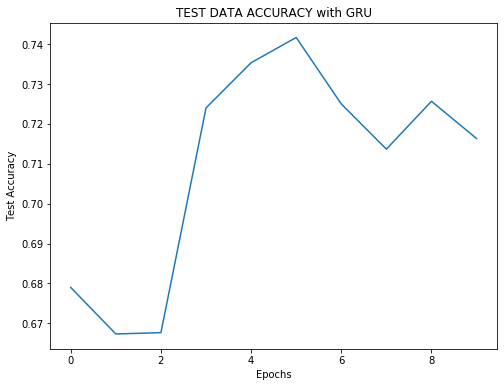

In [16]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(gru_all_test_acc)), gru_all_test_acc)
_ = plt.title("TEST DATA ACCURACY with GRU")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Test Accuracy")

### Further testing on testset with GRU to see where it went wrong

In [17]:
# Predict the test set, storing the data to revert to sentenses
gru_model.eval()
gru_data = []
gru_p = []
gru_true = []
for i, data in enumerate(test_loader, 0):
    inputs, labels = data[0].to(gpu_device), data[1].to(gpu_device)
    gru_data.append(inputs)
    gru_p.append(gru_model.predict(inputs))
    gru_true.append(labels)

In [18]:
torch.sum(gru_p[5][5] == gru_true[5][5])

tensor(1, device='cuda:0')

In [19]:
gru_true[5][5]

tensor(1, device='cuda:0')

In [20]:
revert_sentence(gru_data[5][5])

'Hey what do you expect form a very low budget movie Although I havent seen 2002 I can say that following what the media put out about Jeff this is a pretty accurate depiction I have studied the Jeffrey case and learned all I can about this man This is a low budget movie but it shows the mentality of a serial killer If you can get past gore and see what the underlying story of a sick mind I loved this movie Just brace yourself for low budget and no blood Its a story as seen through the eyes of a killer and his actions and thoughts from childhood up through his arrest My favorite line is If they had bothered to look in the back seat it might have saved a lot of lives Enjoy'

## Part 3 - Comparison with a MLP (5 points)

In [21]:
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.fc1 = nn.Linear(400, 128)
        self.fc2 = nn.Linear(128, 64)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds

In [22]:
# Create mlp model
mlp_model = mlp()
mlp_model.to(gpu_device)

mlp(
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
)

In [23]:
# Set the cross-entrophy criterion
mlp_cross_entro = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
mlp_sgd = optim.Adam(mlp_model.parameters(), lr = 0.01)

In [24]:
# Need tensor double intead of tensor long for this
train_data_d = TensorDataset(torch.from_numpy(training_vec).type(torch.FloatTensor),
                           torch.from_numpy(training_label).type(torch.LongTensor))
train_loader_d = DataLoader(train_data_d, shuffle = True, batch_size = 64)

test_data_d = TensorDataset(torch.from_numpy(testing_vec).type(torch.FloatTensor),
                          torch.from_numpy(testing_label).type(torch.LongTensor))
test_loader_d = DataLoader(test_data_d, shuffle = True, batch_size = 64)

In [25]:
mlp_train_acc, mlp_all_train_loss, mlp_all_test_acc, mlp_all_test_loss = train_model(mlp_model, train_loader_d,
                                                                                     test_loader_d, mlp_sgd,
                                                                                     mlp_cross_entro, 10)

Epoch 2 / 10
train --- Accuracy: 0.546  Loss: 0.143
test --- Accuracy: 0.502  Loss: 0.092
Epoch 4 / 10
train --- Accuracy: 0.586  Loss: 0.042
test --- Accuracy: 0.504  Loss: 0.094
Epoch 6 / 10
train --- Accuracy: 0.593  Loss: 0.058
test --- Accuracy: 0.501  Loss: 0.073
Epoch 8 / 10
train --- Accuracy: 0.617  Loss: 0.041
test --- Accuracy: 0.500  Loss: 0.081
Epoch 10 / 10
train --- Accuracy: 0.599  Loss: 0.035
test --- Accuracy: 0.499  Loss: 0.065
